In [237]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import r2_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LogisticRegressionCV

import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm as gbm
from lightgbm import LGBMClassifier

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns

# Data aggregation

In [238]:
match_file = pd.read_csv('dota-2-matches/match.csv')
match_file.head()

,match_id,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,game_mode,radiant_win,negative_votes,positive_votes,cluster
0,0,1446750112,2375,1982,4,3,63,1,22,True,0,1,155
1,1,1446753078,2582,0,1846,63,0,221,22,False,0,2,154
2,2,1446764586,2716,256,1972,63,48,190,22,False,0,0,132
3,3,1446765723,3085,4,1924,51,3,40,22,False,0,0,191
4,4,1446796385,1887,2047,0,0,63,58,22,True,0,0,156


In [239]:
# Util function for data aggregation
# details of bit string is in :
# https://wiki.teamfortress.com/wiki/WebAPI/GetMatchDetails#Player_Slot
def tower_status(ts_radiant, ts_dire):
    tsr = {}
    tsd = {}
    bit_tsr = '{0:016b}'.format(ts_radiant)
    bit_tsd = '{0:016b}'.format(ts_dire)
    tsr['top'] = bit_tsr.count('1', -3)
    tsd['top'] = bit_tsd.count('1', -3)
    tsr['mid'] = bit_tsr.count('1', 10, 13)
    tsd['mid'] = bit_tsd.count('1', 10, 13)
    tsd['bottom'] = bit_tsd.count('1', 7, 10)
    tsr['bottom'] = bit_tsr.count('1', 7, 10)
    tsd['ancient'] = bit_tsd.count('1', 5, 7)
    tsr['ancient'] = bit_tsr.count('1', 5, 7)
    return (tsr, tsd)

def barracks_status(bs_radiant, bs_dire):
    bsr = {}
    bsd = {}
    bit_bsr = '{0:08b}'.format(bs_radiant)
    bit_bsd = '{0:08b}'.format(bs_dire)
    bsr['top'] = bit_bsr.count('1', -2)
    bsd['top'] = bit_bsd.count('1', -2)
    bsr['mid'] = bit_bsr.count('1', 2, 4)
    bsd['mid'] = bit_bsd.count('1', 2, 4)
    bsd['bottom'] = bit_bsd.count('1', 4, 6)
    bsr['bottom'] = bit_bsr.count('1', 4, 6)
    return (bsr, bsd)

In [240]:
df_players = pd.read_csv(
    'dota-2-matches/players.csv', 
    usecols=[
        'match_id',
        'player_slot',
        'gold',
        'gold_spent',
        'kills',
        'deaths',
        'assists',
        'denies',
        'last_hits',
        'hero_damage',
        'tower_damage',
        'level',
        'gold_buyback'
        ])
df_team_fights = pd.read_csv('dota-2-matches/teamfights.csv')
df_team_fights_players = pd.read_csv('dota-2-matches/teamfights_players.csv')


### Novel Features - negative chat

We tried a custom known list of reliably negative words in chat as a novel feature. We count the number of occurrences of each word in the dictionary in chat per team per match.

In [241]:
df_chat = pd.read_csv('dota-2-matches/chat.csv')
df_chat['key'].fillna('', inplace=True)

naughty_words = [
    'stfu',
    'ez',
    'fuck',
    'wtf',
    'blame',
    'report',
    'reported',
    'shit',
    'ass',
    'asshole',
    'idiot',
    'stupid',
    'support',
    'blyat',
    'noob',
    'gg'
]

def get_naughty_count(phrase):
    naughty_count = 0
    tokens = phrase.split()
    for token in tokens:
        naughty_count = naughty_count + (1 if token in naughty_words else 0)
    return naughty_count

df_chat['is_radiant'] = df_chat['slot'] < 5
df_chat['naughty_count'] = df_chat['key'].apply(get_naughty_count)
df_chat.head()

,match_id,key,slot,time,unit,is_radiant,naughty_count
0,0,force it,6,-8,6k Slayer,False,0
1,0,space created,1,5,Monkey,True,0
2,0,hah,1,6,Monkey,True,0
3,0,ez 500,6,9,6k Slayer,False,1
4,0,mvp ulti,4,934,Kira,True,0


In [242]:
df_chat['naughty_count'].describe()

count    1.439488e+06
mean     1.467015e-01
std      3.670513e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      7.000000e+00
Name: naughty_count, dtype: float64

We can see that the median negative word count is 0, and the majority of games have 0 instances of negative words. Thus, later we convert it to a binary feature (present or not).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13d325a50>]],
      dtype=object)

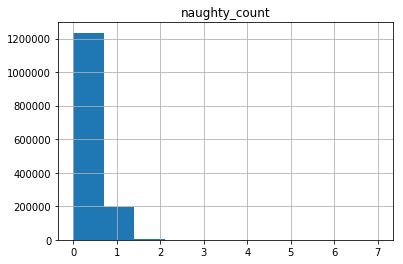

In [243]:
df_naughty_count_only = pd.DataFrame(df_chat['naughty_count'], columns=['naughty_count'])
df_naughty_count_only.hist()

In [244]:
df_match_grouped = df_chat.groupby(['match_id', 'is_radiant'], as_index=False).naughty_count.agg('sum')
df_match_grouped['radiant_naughty_count'] = np.where(df_match_grouped['is_radiant'] == True, df_match_grouped['naughty_count'], 0)
df_match_grouped['dire_naughty_count'] = np.where(df_match_grouped['is_radiant'] == False, df_match_grouped['naughty_count'], 0)
df_match_grouped.head()

,match_id,is_radiant,naughty_count,radiant_naughty_count,dire_naughty_count
0,0,False,2,0,2
1,0,True,3,3,0
2,1,False,1,0,1
3,1,True,0,0,0
4,2,False,2,0,2


In [245]:
df_match_naughty_counts = df_match_grouped.groupby(['match_id']).agg({
    'radiant_naughty_count': 'sum',
    'dire_naughty_count': 'sum'
})

df_match_naughty_counts.head()

,radiant_naughty_count,dire_naughty_count
match_id,,
0,3,2
1,0,1
2,1,2
3,1,2
4,1,3


In [246]:
match_data = []
match_file = match_file[match_file['game_mode'] == 22]
df_players.fillna(0, inplace=True)

radiant_pl = [0,1,2,3,4]
dire_pl = [128,129,130,131,132]
player_features = {
    'gold': 'full_total',
    'gold_spent': 'full_avg',
    'kills': 'only_total',
    'deaths': 'full_total',
    'assists': 'full_avg',
    'denies': 'full_avg',
    'last_hits': 'full_avg',
    'hero_damage': 'full_total',
    'tower_damage': 'full_total',
    'level': 'full_total',
    'gold_buyback': 'full_avg'
    }

### Novel Feature - Teamfight result

In [247]:
def teamfight_result(teamfights):
    loss_d = 0
    loss_r = 0
    for i in list(range(0,int(len(tf)/10))):
        tf_df = teamfights[i*10:(i+1)*10]
        rd = sum(tf_df[tf_df.player_slot.isin(radiant_pl)]['deaths'])
        dd = sum(tf_df[tf_df.player_slot.isin(dire_pl)]['deaths'])  
        if dd < rd:
            loss_r += 1
        elif rd < dd:
            loss_d += 1
    return (loss_r, loss_d)

In [248]:
def stat_agg(types: str, feature_name: str, data_list: str, team_data: dict):
    if types == "only_total":
        team_data[f'{feature_name}_total'] = sum(data_list)
    elif types == "full_total":
        team_data[f'{feature_name}_total'] = sum(data_list)
        team_data[f'{feature_name}_max'] = max(data_list)
        team_data[f'{feature_name}_min'] = min(data_list)
        team_data[f'{feature_name}_std'] = round(np.std(data_list), 4)
    elif types == "full_avg":
        team_data[f'{feature_name}_avg'] = np.average(data_list)
        team_data[f'{feature_name}_max'] = max(data_list)
        team_data[f'{feature_name}_min'] = min(data_list)
        team_data[f'{feature_name}_std'] = round(np.std(data_list), 4)

    return team_data

In [249]:
df_players.dtypes

match_id          int64
player_slot       int64
gold              int64
gold_spent        int64
kills             int64
deaths            int64
assists           int64
denies            int64
last_hits         int64
hero_damage       int64
tower_damage      int64
level             int64
gold_buyback    float64
dtype: object

In [250]:
def aggregation_data(match_id, team, team_data: dict):
    # getting the player list
    player_ids = radiant_pl if team == 'radiant' else dire_pl

    filter_players = (df_players.player_slot.isin(player_ids)) & (df_players.match_id == match_id)
    df_team_players = df_players[filter_players]
    
    for feature in player_features:
        team_data = stat_agg(player_features[feature], feature, df_team_players[feature], team_data)

    return team_data

In [251]:
tf = df_team_fights_players[df_team_fights_players.match_id == 0]


### Final Data Aggregation

In [252]:
for idx, row in match_file.iterrows():
    match_id = row['match_id']
    duration = row['duration']

    # Tower, barracks, ancient status
    tower_radiant, tower_dire = tower_status(row['tower_status_radiant'], row['tower_status_dire'])
    barracks_radiant, barracks_dire = barracks_status(row['barracks_status_radiant'], row['barracks_status_dire'])

    # teamfights result
    loss_radiant, loss_dire = teamfight_result(df_team_fights_players[df_team_fights_players.match_id == match_id])

    # naughty word count
    naughty_counts = None
    try: 
        naughty_counts = df_match_naughty_counts.loc[match_id]
    except:
        pass

    radiant_naughty_count = 0
    dire_naughty_count = 0

    radiant_naughty_count = naughty_counts['radiant_naughty_count'] if naughty_counts is not None else 0
    dire_naughty_count = naughty_counts['radiant_naughty_count'] if naughty_counts is not None else 0

    #-- radiant --#
    # init
    team_radiant = {'match_id': match_id, 'duration': duration}
    # result
    team_radiant['result'] = 1 if row['radiant_win'] else 0
    # tower, barrack, ancient comparison data
    team_radiant['top_towers'] = tower_radiant['top'] - tower_dire['top']
    team_radiant['mid_towers'] = tower_radiant['mid'] - tower_dire['mid']
    team_radiant['bottom_towers'] = tower_radiant['bottom'] - tower_dire['bottom']
    team_radiant['ancient_status'] = tower_radiant['ancient'] - tower_dire['ancient']
    team_radiant['top_barracks'] = barracks_radiant['top'] - barracks_dire['top']
    team_radiant['mid_barracks'] = barracks_radiant['mid'] - barracks_dire['mid']
    team_radiant['bottom_barracks'] = barracks_radiant['bottom'] - barracks_dire['bottom']
    # aggregating data from players, abilities
    team_radiant = aggregation_data(match_id, 'radiant', team_radiant)
    # teamfight
    team_radiant['teamfight_loss'] = loss_radiant
    # naughty count
    team_radiant['has_negative_chat'] = True if radiant_naughty_count > 0 else False

    #-- dire --#
    # init
    team_dire = {'match_id': match_id, 'duration': duration}
    # result
    team_dire['result'] = 0 if row['radiant_win'] else 1
    # tower, barrack, ancient comparison data
    team_dire['top_towers'] = - tower_radiant['top'] + tower_dire['top']
    team_dire['mid_towers'] = - tower_radiant['mid'] + tower_dire['mid']
    team_dire['bottom_towers'] = - tower_radiant['bottom'] + tower_dire['bottom']
    team_dire['ancient_status'] = - tower_radiant['ancient'] + tower_dire['ancient']
    team_dire['top_barracks'] = - barracks_radiant['top'] + barracks_dire['top']
    team_dire['mid_barracks'] = - barracks_radiant['mid'] + barracks_dire['mid']
    team_dire['bottom_barracks'] = - barracks_radiant['bottom'] + barracks_dire['bottom']
    # aggregating data from players, abilities
    team_dire = aggregation_data(match_id, 'dire', team_dire)
    # teamfight
    team_dire['teamfight_loss'] = loss_dire
    # naughty word count
    team_dire['has_negative_chat'] = True if dire_naughty_count > 0 else False

    match_data.append(team_radiant)
    match_data.append(team_dire)

In [253]:
# Permenet storage for the cleaned and aggregated data
df_match_data = pd.DataFrame(match_data)
df_match_data.to_csv('data_clean/cleaned_match_data.csv')

# Model Building

### Util function for model training

In [254]:
# util function for plot building

def plot_roc_curve(y_train, preds_train, y_test, preds_test):
    plt.plot(metrics.roc_curve(y_train, preds_train)[0], metrics.roc_curve(y_train, preds_train)[1],
             color = 'red', label='Train ROC Curve (area = %0.5f)' % roc_auc_score(y_train, preds_train))
    plt.plot(metrics.roc_curve(y_test, preds_test)[0],metrics.roc_curve(y_test, preds_test)[1],
             color = 'blue', label='Test ROC Curve (area = %0.5f)' % roc_auc_score(y_test, preds_test))
    plt.plot([0, 2], [0, 2], color='black', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC')
    plt.legend()
    plt.show()
    sns.set(style='white', rc={'figure.figsize':(10,10)})

In [255]:
def important_stats(y_true, y_pred_proba, summary):
    print("------------------------------------------")
    y_pred_label = pd.Series(y_pred_proba)
    y_pred_label = y_pred_label.map(lambda x: 1 if x > 0.5 else 0)
    print(summary)
    reacll = recall_score(y_true, y_pred_label)
    print('recall:', reacll)
    f1_stat = f1_score(y_true, y_pred_label)
    print('f1_score:', f1_stat)
    accuracyScore= accuracy_score(y_true, y_pred_label)
    print('accuracy_score:', accuracyScore)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_proba)
    auc = metrics.auc(fpr, tpr)
    print('AUC:', auc)
    matrix = pd.crosstab(y_true, y_pred_label, rownames=['True'], colnames=['Predicted'], margins=True)
    print(matrix)
    print("------------------------------------------")

### Loading the data set and initialization

In [256]:
df = pd.read_csv(f'{os.getcwd()}/data_clean/cleaned_match_data.csv')

In [257]:
df.head()

,Unnamed: 0,match_id,duration,result,top_towers,mid_towers,bottom_towers,ancient_status,top_barracks,mid_barracks,...,level_total,level_max,level_min,level_std,gold_buyback_avg,gold_buyback_max,gold_buyback_min,gold_buyback_std,teamfight_loss,has_negative_chat
0,0,0,2375,1,1,3,2,2,0,2,...,100,24,16,3.0332,-414.2,0.0,-1056.0,507.4550,1,True
1,1,0,2375,0,-1,-3,-2,-2,0,-2,...,84,19,12,2.6382,-668.4,0.0,-2240.0,884.9065,11,True
2,2,1,2582,0,-2,-2,-1,-2,-2,-2,...,92,25,12,4.4091,-355.0,0.0,-1112.0,410.7768,10,False
3,3,1,2582,1,2,2,1,2,2,2,...,111,25,20,2.3152,-342.4,0.0,-1392.0,539.2356,2,False
4,4,2,2716,0,-1,-2,-1,-2,-2,0,...,80,19,13,2.1909,0.0,0.0,0.0,0.0000,8,True


In [258]:
df.shape

(97340, 54)

In [259]:
df.dtypes

Unnamed: 0              int64
match_id                int64
duration                int64
result                  int64
top_towers              int64
mid_towers              int64
bottom_towers           int64
ancient_status          int64
top_barracks            int64
mid_barracks            int64
bottom_barracks         int64
gold_total              int64
gold_max                int64
gold_min                int64
gold_std              float64
gold_spent_avg        float64
gold_spent_max          int64
gold_spent_min          int64
gold_spent_std        float64
kills_total             int64
deaths_total            int64
deaths_max              int64
deaths_min              int64
deaths_std            float64
assists_avg           float64
assists_max             int64
assists_min             int64
assists_std           float64
denies_avg            float64
denies_max              int64
denies_min              int64
denies_std            float64
last_hits_avg         float64
last_hits_

In [260]:
df.head()
df = df.drop(columns = ['match_id','Unnamed: 0'])

In [261]:
df.corr()

,duration,result,top_towers,mid_towers,bottom_towers,ancient_status,top_barracks,mid_barracks,bottom_barracks,gold_total,...,level_total,level_max,level_min,level_std,gold_buyback_avg,gold_buyback_max,gold_buyback_min,gold_buyback_std,teamfight_loss,has_negative_chat
duration,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.230393,...,0.867515,0.776659,0.780951,0.063224,-0.585446,-0.213387,-0.602820,0.582075,0.242865,0.047288
result,0.000000,1.000000,0.780383,0.869118,0.825150,0.986854,0.809060,0.865912,0.942937,0.739364,...,0.320451,0.318160,0.293043,0.059134,0.189747,0.061800,0.161707,-0.154202,-0.565127,0.000000
top_towers,0.000000,0.780383,1.000000,0.807993,0.792817,0.790515,0.880296,0.752830,0.787292,0.548155,...,0.278441,0.296039,0.246086,0.088415,0.141131,0.036464,0.121163,-0.118319,-0.517812,0.000000
mid_towers,0.000000,0.869118,0.807993,1.000000,0.856399,0.880309,0.738982,0.801978,0.914213,0.613872,...,0.324320,0.338086,0.292913,0.083000,0.142121,0.024963,0.131729,-0.133516,-0.609846,0.000000
bottom_towers,0.000000,0.825150,0.792817,0.856399,1.000000,0.836555,0.735891,0.903572,0.836020,0.581170,...,0.296908,0.312002,0.265209,0.084615,0.151632,0.039077,0.132218,-0.129588,-0.555111,0.000000
ancient_status,0.000000,0.986854,0.790515,0.880309,0.836555,1.000000,0.817134,0.876071,0.955101,0.734006,...,0.322183,0.321548,0.293756,0.062804,0.187248,0.054420,0.161586,-0.155769,-0.571964,0.000000
top_barracks,0.000000,0.809060,0.880296,0.738982,0.735891,0.817134,1.000000,0.771422,0.793796,0.602863,...,0.263630,0.268691,0.235660,0.066975,0.156431,0.043244,0.131539,-0.125817,-0.473552,0.000000
mid_barracks,0.000000,0.865912,0.752830,0.801978,0.903572,0.876071,0.771422,1.000000,0.854986,0.643068,...,0.288824,0.292350,0.260677,0.065643,0.169189,0.047936,0.144604,-0.139372,-0.519806,0.000000
bottom_barracks,0.000000,0.942937,0.787292,0.914213,0.836020,0.955101,0.793796,0.854986,1.000000,0.697307,...,0.321704,0.324197,0.292217,0.067838,0.175141,0.039243,0.156719,-0.154454,-0.580592,0.000000
gold_total,0.230393,0.739364,0.548155,0.613872,0.581170,0.734006,0.602863,0.643068,0.697307,1.000000,...,0.449840,0.421394,0.408975,0.054353,0.029177,-0.007021,0.016350,-0.021104,-0.376337,0.006559


In [262]:
#Drop highly correlated features
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column]>0.6)]
df.drop(to_drop,axis=1,inplace=True)
df.head()

,duration,result,deaths_total,denies_avg,denies_min,level_std,gold_buyback_avg,gold_buyback_max,has_negative_chat
0,2375,1,17,6.0,1,3.0332,-414.2,0.0,True
1,2375,0,52,7.6,0,2.6382,-668.4,0.0,True
2,2582,0,53,5.4,0,4.4091,-355.0,0.0,False
3,2582,1,37,3.2,0,2.3152,-342.4,0.0,False
4,2716,0,49,2.0,0,2.1909,0.0,0.0,True


In [263]:
x_train, x_test, y_train, y_test = train_test_split(
    df.drop(columns = ['result','duration']),
    df['result'],
    test_size=0.2,
    random_state=1
)

In [264]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 1)

### XGBoost

In [265]:
xgb = XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1,
                      n_estimators=100, max_depth=3)
model = xgb.fit(x_train, y_train)
y_pred_test = xgb.predict_proba(x_test)[:, 1]
y_pred_train = xgb.predict_proba(x_train)[:, 1]
important_stats(y_train, y_pred_train, "train result summary: ")
important_stats(y_test, y_pred_test, "test result summary: ")

------------------------------------------
train result summary: 
recall: 0.6941138835572617
f1_score: 0.7568981756026092
accuracy_score: 0.7762653097259901
AUC: 0.8544377038191739
Predicted      0      1    All
True                          
0          11490   8265  19755
1          11586   8454  20040
All        23076  16719  39795
------------------------------------------
------------------------------------------
test result summary: 
recall: 0.6896090534979424
f1_score: 0.7531037582158305
accuracy_score: 0.7742449147318676
AUC: 0.8509072664056022
Predicted     0     1   All
True                       
0          1140   833  1973
1          1186   851  2037
All        2326  1684  4010
------------------------------------------


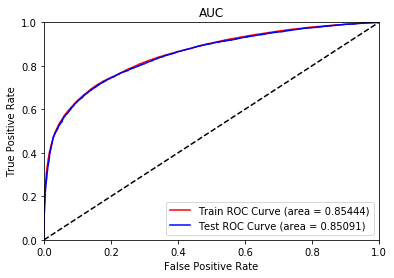

In [266]:
%matplotlib inline
plot_roc_curve(y_train, y_pred_train, y_test, y_pred_test)

### GBDT

In [267]:
gbdt = GradientBoostingClassifier(random_state=0, n_estimators=10, max_depth=10)
gbdt = gbdt.fit(x_train, y_train)
y_pred_test = gbdt.predict_proba(x_test)[:, 1]
y_pred_train = gbdt.predict_proba(x_train)[:, 1]
important_stats(y_train, y_pred_train, "train result summary: ")
important_stats(y_test, y_pred_test, "test result summary: ")

------------------------------------------
train result summary: 
recall: 0.7428982725527831
f1_score: 0.798892290756476
accuracy_score: 0.8123184101963177
AUC: 0.8898988331080125
Predicted      0      1    All
True                          
0          11270   8485  19755
1          11322   8718  20040
All        22592  17203  39795
------------------------------------------
------------------------------------------
test result summary: 
recall: 0.7044238683127572
f1_score: 0.7538258284707696
accuracy_score: 0.7702897061845079
AUC: 0.8456451233639146
Predicted     0     1   All
True                       
0          1117   856  1973
1          1140   897  2037
All        2257  1753  4010
------------------------------------------


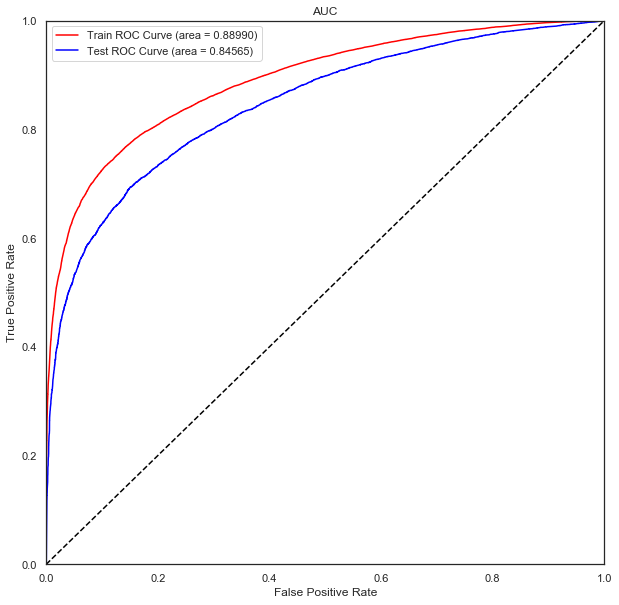

In [268]:
plot_roc_curve(y_train, y_pred_train, y_test, y_pred_test)

### LightGBM

In [269]:
gbm_clf = gbm.LGBMClassifier(
    boosting_type = 'gbdt',
    #num_leaves = ,
    #max_depth = ,
    learning_rate = 0.1
    #n_estimators = 
    #,subsample_for_bin =
    ,objective = 'binary'
    ,metric = 'binary_logloss'
    #,class_weight = 
    #,min_split_gain =
    #,min_split_weight =
    #,min_child_weight =
    #,min_child_samples =
    #,subsample =
    #,subsample_freq =
    #,colsample_bytree =
    ,reg_alpha = 5
    ,reg_lambda = 120
    ,importance_type = 'split' #will rank features by # of times it is used in model.'gain' for gain
    ,num_iterations = 1000
)

In [270]:
gbm_clf.fit(
    x_train, 
    y_train, 
    eval_metric = 'result', 
    verbose = True, 
    eval_set = [(x_val, y_val)],
    early_stopping_rounds = 20
)

[1]	valid_0's binary_logloss: 0.662861
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.637722
[3]	valid_0's binary_logloss: 0.616462
[4]	valid_0's binary_logloss: 0.598544
[5]	valid_0's binary_logloss: 0.583187
[6]	valid_0's binary_logloss: 0.570031
[7]	valid_0's binary_logloss: 0.558754
[8]	valid_0's binary_logloss: 0.54899
[9]	valid_0's binary_logloss: 0.540151
[10]	valid_0's binary_logloss: 0.532668
[11]	valid_0's binary_logloss: 0.525932
[12]	valid_0's binary_logloss: 0.520214
[13]	valid_0's binary_logloss: 0.515268
[14]	valid_0's binary_logloss: 0.510909
[15]	valid_0's binary_logloss: 0.506911
[16]	valid_0's binary_logloss: 0.503441
[17]	valid_0's binary_logloss: 0.500306
[18]	valid_0's binary_logloss: 0.497588
[19]	valid_0's binary_logloss: 0.495152
[20]	valid_0's binary_logloss: 0.492824
[21]	valid_0's binary_logloss: 0.490803
[22]	valid_0's binary_logloss: 0.48906
[23]	valid_0's binary_logloss: 0.487419
[24]	valid_0's binary_logloss:

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               metric='binary_logloss', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_iterations=1000, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=5,
               reg_lambda=120, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [271]:
y_pred_test = gbm_clf.predict_proba(x_test)[:, 1]
y_pred_train = gbm_clf.predict_proba(x_train)[:, 1]
important_stats(y_train, y_pred_train, "train result summary: ")
important_stats(y_test, y_pred_test, "test result summary: ")

------------------------------------------
train result summary: 
recall: 0.7262316058861165
f1_score: 0.7723476278769115
accuracy_score: 0.7851742459508484
AUC: 0.8660834159901322
Predicted      0      1    All
True                          
0          11014   8741  19755
1          11150   8890  20040
All        22164  17631  39795
------------------------------------------
------------------------------------------
test result summary: 
recall: 0.7155349794238683
f1_score: 0.7613574165298304
accuracy_score: 0.7760427367988494
AUC: 0.8544830394669962
Predicted     0     1   All
True                       
0          1096   877  1973
1          1140   897  2037
All        2236  1774  4010
------------------------------------------


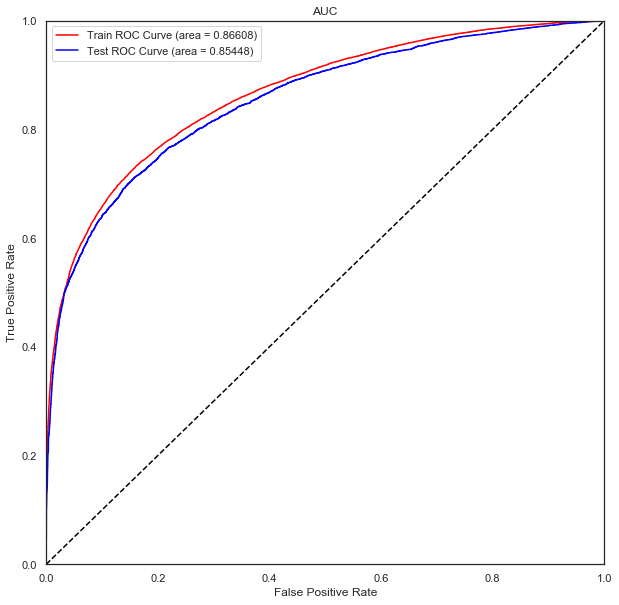

In [272]:
plot_roc_curve(y_train, y_pred_train, y_test, y_pred_test)

### GridSearch for GBDT

In [273]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=300,
                                                               min_samples_leaf=20,max_depth=8,max_features='sqrt',
                                                               subsample=0.8,random_state=10), 
                        param_grid = param_test1, scoring='roc_auc',iid=False,cv=5)
gsearch1.fit(df.drop(columns = ['result','duration']),df['result'])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([1.18589277, 1.75672255, 2.3179038 , 2.85591702, 3.43987155,
         4.39900851, 4.59655123]),
  'std_fit_time': array([0.03619218, 0.01933421, 0.06160265, 0.03179153, 0.12833467,
         0.17601816, 0.15251512]),
  'mean_score_time': array([0.03278232, 0.04221201, 0.04960127, 0.05456357, 0.06191044,
         0.07364426, 0.07276506]),
  'std_score_time': array([0.00061949, 0.00232535, 0.00196299, 0.00048463, 0.00196626,
         0.0015026 , 0.00270393]),
  'param_n_estimators': masked_array(data=[20, 30, 40, 50, 60, 70, 80],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 20},
   {'n_estimators': 30},
   {'n_estimators': 40},
   {'n_estimators': 50},
   {'n_estimators': 60},
   {'n_estimators': 70},
   {'n_estimators': 80}],
  'split0_test_score': array([0.84704343, 0.84934   , 0.85066351, 0.85164848, 0.85233725,
         0.85252898, 0.85273903]),
  'spl

In [274]:
param_test1 = {'n_estimators':range(80,151,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=300,
                                                               min_samples_leaf=20,max_depth=8,max_features='sqrt',
                                                               subsample=0.8,random_state=10), 
                        param_grid = param_test1, scoring='roc_auc',iid=False,cv=5)
gsearch1.fit(df.drop(columns = ['result','duration']),df['result'])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([4.49697628, 5.01665998, 5.44260459, 5.96744561, 6.48579392,
         6.98027577, 7.64321055, 8.06507726]),
  'std_fit_time': array([0.03594253, 0.07112514, 0.03123464, 0.05553373, 0.05426594,
         0.03553206, 0.11960741, 0.08641089]),
  'mean_score_time': array([0.0742712 , 0.07820964, 0.0815258 , 0.08630128, 0.09127488,
         0.09622941, 0.10427294, 0.10570512]),
  'std_score_time': array([0.00099604, 0.00167455, 0.00093926, 0.00116354, 0.00110176,
         0.00118578, 0.00201494, 0.00133661]),
  'param_n_estimators': masked_array(data=[80, 90, 100, 110, 120, 130, 140, 150],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 80},
   {'n_estimators': 90},
   {'n_estimators': 100},
   {'n_estimators': 110},
   {'n_estimators': 120},
   {'n_estimators': 130},
   {'n_estimators': 140},
   {'n_estimators': 150}],
  'split0_test_score': array([0.852

In [275]:
param_test2 = {'max_depth':range(3,14,2), 'min_samples_split':range(100,801,200)}
gsearch2 = GridSearchCV(
    estimator = GradientBoostingClassifier(
        learning_rate=0.1, 
        n_estimators=120, 
        min_samples_leaf=20,
        max_features='sqrt', 
        subsample=0.8, 
        random_state=10
    ), 
    param_grid = param_test2, 
    scoring='roc_auc',
    iid=False, 
    cv=5)
gsearch2.fit(df.drop(columns = ['result','duration']),df['result'])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([ 3.48853068,  3.39634099,  3.39455457,  3.43347812,  4.64345179,
          4.60082121,  4.56209478,  4.56678076,  6.34000621,  5.86132083,
          5.73890586,  5.69404888,  7.5066227 ,  7.41571236,  7.14768195,
          6.95553279,  9.45066652,  8.55600491,  8.26806479,  8.0076838 ,
         11.34809875,  9.93848939,  9.26545234,  8.86286163]),
  'std_fit_time': array([0.11076404, 0.02538327, 0.01496   , 0.03094978, 0.05813355,
         0.04708578, 0.02209854, 0.07126331, 0.49522405, 0.03737676,
         0.03268715, 0.01363775, 0.07619449, 0.32928721, 0.09114357,
         0.20452219, 0.12739237, 0.11304985, 0.09440511, 0.14671984,
         0.28810278, 0.36388441, 0.29953594, 0.1161987 ]),
  'mean_score_time': array([0.05202641, 0.05200176, 0.05119538, 0.05212131, 0.06980042,
         0.06802421, 0.06749463, 0.06770535, 0.08623476, 0.08358855,
         0.08128104, 0.08558702, 0.10602479, 0.1024652 , 0.09826579,
         0.10148697, 0.12903781, 0.1191082 , 0.

In [276]:
param_test3 = {'min_samples_leaf':range(60,101,10)}
gsearch3 = GridSearchCV(
    estimator = GradientBoostingClassifier(
        learning_rate=0.1, 
        n_estimators=120,
        max_depth=7,
        min_samples_split=700,
        max_features='sqrt', 
        subsample=0.8, 
        random_state=10
    ), 
    param_grid = param_test3, 
    scoring='roc_auc',
    iid=False, 
    verbose=1,
    cv=5
)

gsearch3.fit(df.drop(columns = ['result','duration']),df['result'])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.5min finished


({'mean_fit_time': array([5.79782844, 5.85214982, 5.76163898, 5.91523104, 5.81000743]),
  'std_fit_time': array([0.15607121, 0.08187269, 0.11168804, 0.26937505, 0.22457809]),
  'mean_score_time': array([0.08212223, 0.08508878, 0.08615308, 0.08794856, 0.08320065]),
  'std_score_time': array([0.00164248, 0.00373827, 0.00396298, 0.00776839, 0.00141486]),
  'param_min_samples_leaf': masked_array(data=[60, 70, 80, 90, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'min_samples_leaf': 60},
   {'min_samples_leaf': 70},
   {'min_samples_leaf': 80},
   {'min_samples_leaf': 90},
   {'min_samples_leaf': 100}],
  'split0_test_score': array([0.85232657, 0.85251935, 0.85263793, 0.85249281, 0.85259465]),
  'split1_test_score': array([0.85587165, 0.85583704, 0.8558496 , 0.85601258, 0.85598933]),
  'split2_test_score': array([0.85217107, 0.85179541, 0.85174686, 0.85186248, 0.85188482]),
  'split3_test_score': array([0.8

In [277]:
gbdt_best = GradientBoostingClassifier(
    learning_rate=0.1, 
    n_estimators=100,
    max_depth=9, 
    min_samples_leaf =80, 
    min_samples_split =700, 
    max_features='sqrt', 
    subsample=0.8, 
    random_state=10
)
gbdt_best.fit(df.drop(columns = ['result','duration']),df['result'])

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=9,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=80, min_samples_split=700,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=10, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [278]:
y_pred_test = gbdt_best.predict_proba(x_test)[:, 1]
y_pred_train = gbdt_best.predict_proba(x_train)[:, 1]
important_stats(y_train, y_pred_train, "train result summary: ")
important_stats(y_test, y_pred_test, "test result summary: ")

------------------------------------------
train result summary: 
recall: 0.7201855406269994
f1_score: 0.7708611539120014
accuracy_score: 0.7851581938135063
AUC: 0.8677326440769485
Predicted      0      1    All
True                          
0          11153   8602  19755
1          11243   8797  20040
All        22396  17399  39795
------------------------------------------
------------------------------------------
test result summary: 
recall: 0.7196502057613169
f1_score: 0.7705866152575048
accuracy_score: 0.7860591740291761
AUC: 0.8680424368995814
Predicted     0     1   All
True                       
0          1106   867  1973
1          1151   886  2037
All        2257  1753  4010
------------------------------------------


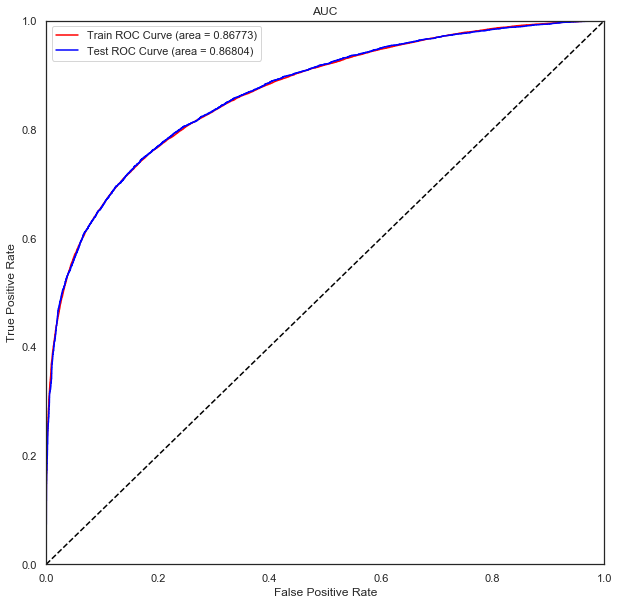

In [279]:
plot_roc_curve(y_train, y_pred_train, y_test, y_pred_test)

### Features importance

In [280]:
gbdt_importance = gbdt_best.feature_importances_

Text(0.5, 0, 'Relative Importance: Gini')

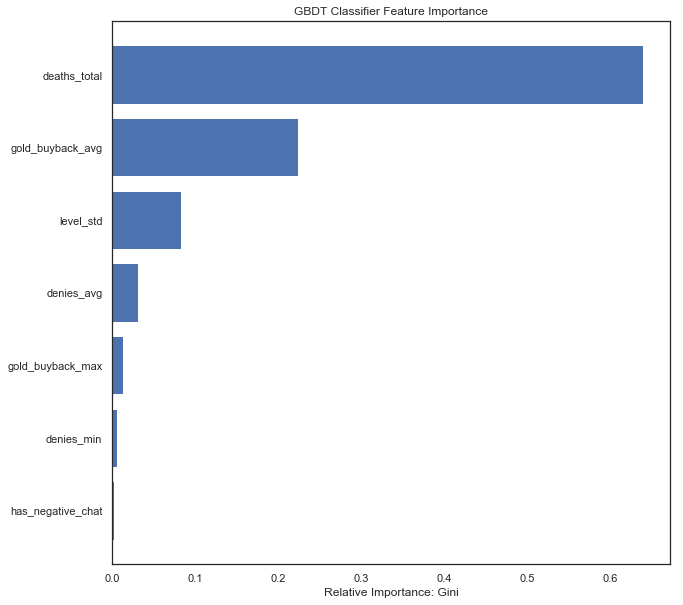

In [281]:
from matplotlib.pyplot import figure
figure(num=None, figsize = (10,10))
indices = np.argsort(gbdt_importance)
plt.figure(1)
plt.title('GBDT Classifier Feature Importance')
plt.barh(range(len(indices)), gbdt_importance[indices], color = 'b', align = 'center')
gbdt_feat_names = x_train.columns
plt.yticks(range(len(indices)), gbdt_feat_names[indices])
plt.xlabel('Relative Importance: Gini')

### Logistic Regression for predicting probabilities

In [282]:
lr = LogisticRegressionCV(solver = 'saga',
                           penalty = 'elasticnet',
                           l1_ratios = [0.1, 0.2, 0.3],
                           Cs = 20,
                           n_jobs = -1,
                           random_state = 0,
                           class_weight = 0.9
)
lr.fit(x_train,y_train)

LogisticRegressionCV(Cs=20, class_weight=0.9, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=[0.1, 0.2, 0.3], max_iter=100,
                     multi_class='auto', n_jobs=-1, penalty='elasticnet',
                     random_state=0, refit=True, scoring=None, solver='saga',
                     tol=0.0001, verbose=0)

In [283]:
y_pred_test = lr.predict_proba(x_test)[:, 1]
y_pred_train = lr.predict_proba(x_train)[:, 1]
important_stats(y_train, y_pred_train, "train result summary: ")
important_stats(y_test, y_pred_test, "test result summary: ")

------------------------------------------
train result summary: 
recall: 0.5585412667946257
f1_score: 0.6477582592888015
accuracy_score: 0.6951859640111081
AUC: 0.7676367536354921
Predicted      0      1    All
True                          
0          12585   7170  19755
1          12738   7302  20040
All        25323  14472  39795
------------------------------------------
------------------------------------------
test result summary: 
recall: 0.5618312757201646
f1_score: 0.6489987521540198
accuracy_score: 0.6965790014382577
AUC: 0.7677052884964479
Predicted     0     1   All
True                       
0          1251   722  1973
1          1266   771  2037
All        2517  1493  4010
------------------------------------------


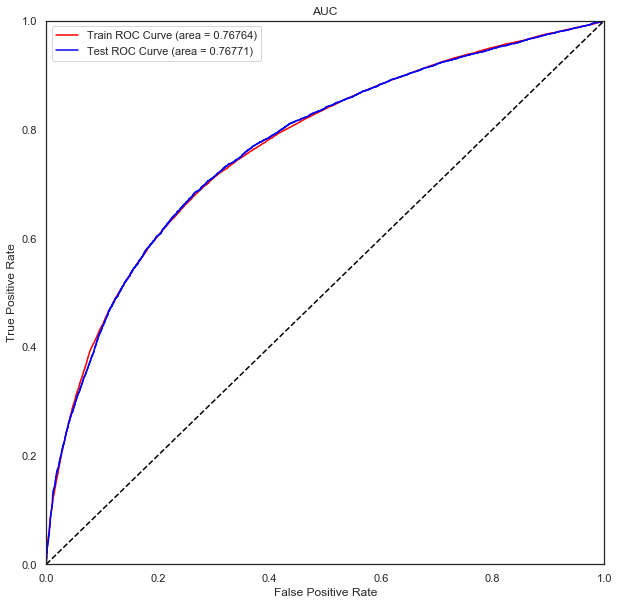

In [284]:
plot_roc_curve(y_train, y_pred_train, y_test, y_pred_test)